<a href="https://colab.research.google.com/github/diegoeduardok/tox21_workshop/blob/main/Tox21_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note**: please change your runtime to "T4 GPU" under **`Runtime > Change runtime type`** before running the code below. If you do not have access to a GPU runtime, then upload `molformer_embeddings.npy` (available with other [supplementary files](https://drive.google.com/drive/folders/1KcUpWwdEz2y418TK6iWZd-d4wVlCuaYC?usp=drive_link)) during the **`Clean data`** section and skip the **`Generate embeddings`** section.

# Tox21 Classification Workshop

The goal of this workshop activity is to train a classifier to predict the toxicity of molecules based on their structure.

We will utilize the public Tox21 data set, available here: https://tripod.nih.gov/tox/index.html?login=/tox/sec/toxdatadownload

More details about this data set are also presented here: https://ncats.nih.gov/research/research-activities/Tox21/assays

We will also use a version of the data that was further processed by researchers in Johannes Kepler University and can be found here: http://bioinf.jku.at/research/DeepTox/tox21.html

The activity is divided into three sections:



1.   Clean data
2.   Generate embeddings
3.   Train model



# Clean data

Before starting, make sure to have the following files (available in [supplementary files](https://drive.google.com/drive/folders/1KcUpWwdEz2y418TK6iWZd-d4wVlCuaYC?usp=drive_link)) in your parent directory (click the folder icon on the left bar to see your files).

- `tox21_labels_train.csv`
- `tox21_10k_library_info.tsv`

You can upload files by clicking the `Upload to session storage` icon (document icon with an upward arrow). After you have uploaded the files, you can start running this section of the notebook.

First, we install a required cheminformatics package ([RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html)) and import all relevant packages.

In [1]:
! pip install rdkit

In [2]:
import numpy as np
import pandas as pd

from rdkit import Chem

import torch
from transformers import AutoModel, AutoTokenizer

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

Read the labels from the Tox21 assays.

In [3]:
labels = pd.read_csv("tox21_labels_train.csv") # From http://bioinf.jku.at/research/DeepTox/tox21.html

We can look at the contents of the file by running the cell below.

In [4]:
labels

,Unnamed: 0,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,NCGC00178831-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,NCGC00166114-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,NCGC00263563-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,NCGC00013058-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,NCGC00167516-01,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12055,NCGC00261292-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12056,NCGC00261245-01,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
12057,NCGC00260828-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12058,NCGC00260687-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Read the information about the samples.

In [5]:
samples = pd.read_csv("tox21_10k_library_info.tsv", delimiter="\t") # From https://tripod.nih.gov/tox/index.html?login=/tox/sec/toxdatadownload

Let's look at the contents of this other file.

In [6]:
samples

,SAMPLE_ID,TOX21_ID,CAS,PUBCHEM_SID,SAMPLE_NAME,PURITY_RATING,PURITY_RATING_4M,PUBCHEM_CID,LAST_MODIFIED,SMILES
0,NCGC00255864-01,Tox21_301239,1155-74-4,144211556,Tetradecylpyridinium bromide,A,A,62379.0,16-JAN-19 01.02.54.000000000 PM,[Br-].CCCCCCCCCCCCCC[n+]1ccccc1
1,NCGC00255879-01,Tox21_301645,124-76-5,144211962,Isoborneol,A,A,6321405.0,16-JAN-19 01.02.54.000000000 PM,C[C@]12CC[C@H](C[C@H]1O)C2(C)C
2,NCGC00256067-01,Tox21_301339,34562-31-7,144211656,"3,5-Diethyl-1-phenyl-2-propyl-1,2-dihydropyridine",D,NaN,118703.0,16-JAN-19 01.02.54.000000000 PM,CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC
3,NCGC00256074-01,Tox21_301928,7397-62-8,144212245,Butyl hydroxyacetate,A,A,81882.0,16-JAN-19 01.02.54.000000000 PM,OCC(=O)OCCCC
4,NCGC00255047-01,Tox21_301149,94-09-7,144211466,Benzocaine,A,A,2337.0,16-JAN-19 01.02.54.000000000 PM,Nc1ccc(cc1)C(=O)OCC
...,...,...,...,...,...,...,...,...,...,...
13123,NCGC00016403-01,Tox21_110423,138-37-4,144203974,Mafenide hydrochloride,A,NaN,67313.0,16-JAN-19 01.02.54.000000000 PM,Cl.O=S(N)(=O)c1ccc(CN)cc1
13124,NCGC00016662-01,Tox21_110551,5874-97-5,144204102,Orciprenaline sulfate,F,NaN,441333.0,16-JAN-19 01.02.54.000000000 PM,Oc1cc(cc(O)c1)C(O)CNC(C)C.O=S(=O)(O)O.CC(C)NCC...
13125,NCGC00018255-04,Tox21_113569,68-88-2,144207118,Hydroxyzine,A,A,3658.0,16-JAN-19 01.02.54.000000000 PM,Clc1ccc(cc1)C(c2ccccc2)N3CCN(CC3)CCOCCO
13126,NCGC00022248-03,Tox21_113501,125-04-2,144207050,Hydrocortisone 21-hemisuccinate sodium salt,D,D,23694214.0,16-JAN-19 01.02.54.000000000 PM,[Na+].[O-]C(=O)CCC(=O)OCC(=O)[C@@]4(O)CC[C@@H]...


Now, we will merge the information about the samples with the labels. For this purpose, we will match the samples by their ID.

In [7]:
merged = pd.merge(labels, samples, left_on="Unnamed: 0", right_on="SAMPLE_ID")

In [8]:
new_merged = merged.drop("Unnamed: 0", axis=1) # Drop a redundant column for clarity

In this step, we read the chemical structure from each sample, encoded as a [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) string, and write it in RDKit's canonical SMILES format. Notice that not all molecules may be interpreted correctly by RDKit, which might result in output lines informing us of the issues. For the purposes of this workshop, we will avoid using the samples that cannot be understood by RDKit.

In [9]:
smiles = []
for i, smi in enumerate(new_merged["SMILES"]):
  try:
    canonical = Chem.CanonSmiles(smi)
  except Exception:
    canonical = "NA"
  smiles.append(canonical)

[17:24:32] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 28 29 30 31
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38 39 40 41 42
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 29 30 31 32
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 16
[17:24:32] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[17:24:32] Can't

We add a new column to our data set containing the canonical SMILES.

In [10]:
new_merged["CANONICAL SMILES"] = smiles

Here, we drop the samples that could not be understood by RDKit. Although we are not done processing the data, we save it to a .csv file. It is good practice to keep intermediate checkpoints in case something goes wrong.

In [11]:
new_merged[new_merged["CANONICAL SMILES"] != "NA"].to_csv("tox21_checkpoint.csv")

Again, we can look at the data directly on the notebook by running the cell below.

In [12]:
new_merged

,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,...,TOX21_ID,CAS,PUBCHEM_SID,SAMPLE_NAME,PURITY_RATING,PURITY_RATING_4M,PUBCHEM_CID,LAST_MODIFIED,SMILES,CANONICAL SMILES
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,Tox21_111337_1,69235-50-3,170465670,Acriflavine hydrochloride,I,NaN,443101.0,16-JAN-19 01.02.54.000000000 PM,[Cl-].C[n+]1c3cc(N)ccc3cc2ccc(N)cc12.Nc1cc2nc3...,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.Nc1ccc2cc3ccc(N...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,Tox21_112323_1,17372-87-1,170466832,Eosin,F,NaN,11048.0,16-JAN-19 01.02.54.000000000 PM,[Na+].[Na+].[O-]C(=O)c4ccccc4C=2c3cc(Br)c([O-]...,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,Tox21_113443_1,84878-61-5,170466228,Maduramicin ammonium,F,NaN,20054964.0,16-JAN-19 01.02.54.000000000 PM,[NH4+].O[C@]1(CC([O-])=O)O[C@H]([C@H](OC)[C@@H...,CO[C@@H]1[C@@H](OC)[C@H](C)[C@@](O)(CC(=O)[O-]...
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,Tox21_110008_1,2437-29-8,170465712,Malachite green oxalate,A,NaN,2724411.0,16-JAN-19 01.02.54.000000000 PM,C/[N+](C)=C1\C=C/C(C=C1)=C(/c2ccccc2)c3ccc(cc3...,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)c...
4,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Tox21_112514,82318-06-7,144206067,Deslorelin acetate,NaN,NaN,25077533.0,16-JAN-19 01.02.54.000000000 PM,CC(=O)O.O=C1CC[C@H](N1)C(=O)N[C@@H](Cc2cncn2)C...,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Tox21_201741,51-52-5,144208939,6-Propyl-2-thiouracil,A,A,657298.0,16-JAN-19 01.02.54.000000000 PM,S=C1NC(CCC)=CC(=O)N1,CCCc1cc(=O)[nH]c(=S)[nH]1
11760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Tox21_201294,96-45-7,144208492,Ethylene thiourea,A,Ac,2723650.0,16-JAN-19 01.02.54.000000000 PM,S=C1NCCN1,S=C1NCCN1
11761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Tox21_301034,96-45-7,144211351,Ethylene thiourea,A,Ac,2723650.0,16-JAN-19 01.02.54.000000000 PM,S=C1NCCN1,S=C1NCCN1
11762,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Tox21_300663,56-38-2,144210980,Parathion,A,Ac,991.0,16-JAN-19 01.02.54.000000000 PM,S=P(Oc1ccc(cc1)[N+]([O-])=O)(OCC)OCC,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1


In the following lines, we read the checkpoint that we saved and process the data that will correspond to the training labels.

In [13]:
df = pd.read_csv("tox21_checkpoint.csv")

Here we take the data from the columns corresponding to the assay labels and cast them into a numerical array (`labels_arr`).

In [14]:
assays = ["NR.AhR", "NR.AR", "NR.AR.LBD", "NR.Aromatase", "NR.ER", "NR.ER.LBD", "NR.PPAR.gamma", "SR.ARE", "SR.ATAD5", "SR.HSE", "SR.MMP", "SR.p53"]
labels_arr = torch.vstack([torch.Tensor(df[k].to_list()) for k in assays])

The resulting array contains `0` for negative results (=not toxic), `1` for positive results (=toxic), and `nan` for inconclusive results. Since our array contains many `nan` entries (samples that returned inconclusive results in the original assays), we need to make a decision about how to treat them. Although different choices are possible, we will use the following conventions to create our training data:

For a given compound:
*   If any of the assays resulted positive, it is considered toxic (label = 1).
*   If none of the assays were positive, but any of them were inconclusive, then it is inconclusive (label = -1).
*   If all the assays resulted negative, then it is considered non-toxic (label = 0).

We will use the following trick to easily encode these rules. We can see that there is a "hierarchy" such that one assay result can override all others (positive > inconclusive > negative). Then, we replace all `nan` with a number between `0` and `1` (e.g., `0.5`), and select the maximum number that we observe for each compound. Then, we convert the `0.5` into `-1`. The resulting array will be used as our training labels.



In [15]:
labels_arr_no_nans = labels_arr
labels_arr_no_nans[torch.isnan(labels_arr)] = .5

In [16]:
summary_labels = torch.max(labels_arr_no_nans, axis=0).values

In [17]:
summary_labels[torch.where(torch.abs(summary_labels-0.5) < .001)] = -1

In [18]:
df['SUMMARY LABEL'] = summary_labels.long() # Convert to integers

In [19]:
df.drop("Unnamed: 0", axis=1).to_csv("tox21_workshop.csv") # Drop redundant column and save

After running these last few cells, we have added the labels in a new column and saved our data again.

# Generate embeddings

This section is about converting the chemical structures of the compounds into numerical vectors that can be fed into a machine learning model.

For this purpose, we will use a Large Language Model (LLM) trained on SMILES strings, called the MolFormer. This model takes the structure of a chemical and outputs a vector that encodes relevant information (mostly in a non-interpretable fashion). More information about this model is available here: https://arxiv.org/pdf/2106.09553



We will use a version of the model that was uploaded to HuggingFace (a repository for transformers): https://huggingface.co/ibm/MoLFormer-XL-both-10pct

Here, we load the LLM and the tokenizer. While the LLM is the model itself, the tokenizer helps us transform a SMILES string into a list of tokens that will be fed into the LLM.

In [20]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_molformer.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_molformer_fast.py: 0.00B [00:00, ?B/s]

tokenization_molformer.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [21]:
model.cuda() # Move the model into the GPU to accelerate the computation

MolformerModel(
  (embeddings): MolformerEmbeddings(
    (word_embeddings): Embedding(2362, 768, padding_idx=2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): MolformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x MolformerLayer(
        (attention): MolformerAttention(
          (self): MolformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (rotary_embeddings): MolformerRotaryEmbedding()
            (feature_map): MolformerFeatureMap(
              (kernel): ReLU()
            )
          )
          (output): MolformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (in

Here, we read the data from the previous section of the workshop. In particular, we want to retrieve the canonical SMILES and feed them to the LLM to obtain the embeddings.

In [22]:
df = pd.read_csv("tox21_workshop.csv")
smiles = df["CANONICAL SMILES"].to_list() # Read the data from the canonical smiles that was generated before

Here, we take chunks of `128` molecules and pass them to the LLM to obtain the vectors. We repeat the loop until we have processes all molecules. The molecules cannot be processed all at the same time because that would require too much memory. The resulting vectors are what we call embeddings.

In [23]:
chunk_size = 128
size = len(smiles)
num_chunks = size // chunk_size + 1
embeddings = []
for i in tqdm(range(num_chunks), total=num_chunks):
  start = chunk_size*i
  end = min(chunk_size*(i+1), size)
  smiles_chunk = smiles[start:end]
  with torch.no_grad(): # Use this line to prevent the computation of gradients, which are only used during training
    inputs = tokenizer(smiles_chunk, padding=True, return_tensors="pt") # Tokenize the input
    inp = {k: v.to("cuda") for k, v in inputs.items()} # Move input data to GPU
    outputs = model(**inp) # Run data through LLM
    embeddings.append(outputs.pooler_output.cpu()) # Store embeddings in list

  0%|          | 0/90 [00:00<?, ?it/s]

Finally, we put all the embeddings in the same array and save them for the next section.

In [24]:
emb = torch.vstack(embeddings) # Convert list of arrays to array
np.save("molformer_embeddings.npy", emb.numpy()) # Save results

# Train model

In this section, we will train our classifier. This model will take the embeddings from the LLM and learn to classify the molecule into the toxic or non-toxic categories.

The type of model that we will use is a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) or MLP.

In particular, the implementation that we will use is available in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

## Split data

In this section, we will remove the inconclusive results from our data set. Then we will split our data into two groups, train and test. While the train group will be used to fit the model, the test group will be used to evaluate its performance.

In [25]:
X_total = np.load("molformer_embeddings.npy")
y_total = np.asarray(df["SUMMARY LABEL"].to_list()).astype(int)

In [26]:
X = X_total[np.where(y_total != -1)] # Drop inconclusive
y = y_total[np.where(y_total != -1)] # Drop inconclusive

Here the "stratify" option ensures that our train and test groups contain the same proportion of positive and negative samples. `test_size=0.1` means that `10%` of the data will be used for the test group.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)

## Define and fit the model

The classification model is defined below. The `hidden_layer_sizes` defines the architecture of the model (namely, how many "neurons" there are in each layer of the network). After you are done with the activity, you can play around with this and many other model parameters to check if you can improve the performance!

The model is also fit with our training data in the same line of code.

In [28]:
mlp = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(384, 192, 96, 48, 24, 12, 6)).fit(X_train, y_train)

Then, we plot the loss function to check that our model is improving after each epoch (epoch = a full run through all the data).

The lower the loss function, the more accurate our model is.

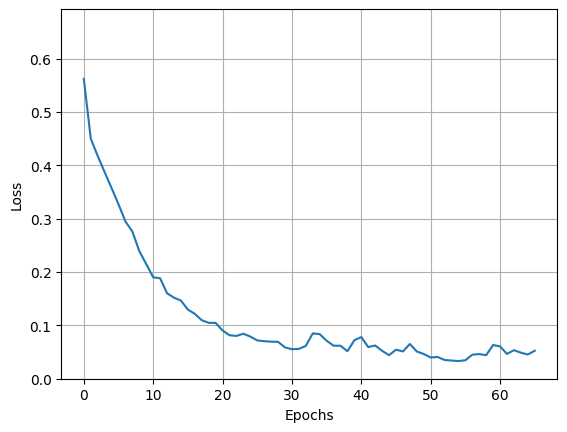

In [29]:
plt.plot(mlp.loss_curve_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.ylim([0, np.log(2)])
plt.show()

## Measure performance

Finally, we measure the performance of the model.

There are several metrics to do this, but we choose to look at the accuracy (fraction of samples classified correctly) and the [F1 Score](https://en.wikipedia.org/wiki/F-score) (harmonic mean of recall and precision).

In [30]:
y_pred = mlp.predict(X_test) # Get model predictions for test set

In [31]:
accuracy_score(y_pred, y_test)

0.8177083333333334

Around 80% of our samples are classified correctly.

In [32]:
f1_score(y_pred, y_test)

0.8559670781893004

The F1-Score should be around 80% too. This metric is often preferred when the number of positive and negative samples is unbalanced.

We can also plot other metrics of performance, such as the [receiver operating characteristic curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC curve) and the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

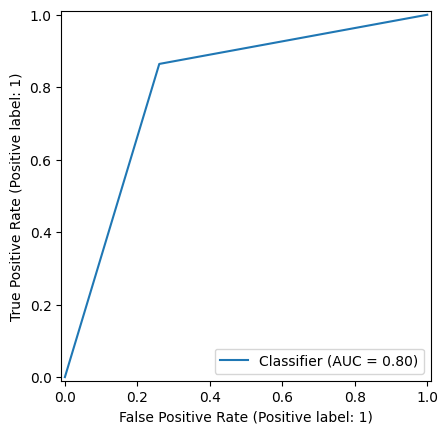

In [33]:
RocCurveDisplay.from_predictions(y_pred=y_pred, y_true=y_test)
plt.show()

In the ROC curve, each point represents the value of the true positive rate (fraction of positive samples that are predicted as positive) for a given tolerance on the false positive rate (fraction of negative samples that are predicted as positive). The closer the area under this curve is to `1`, the better our model is.

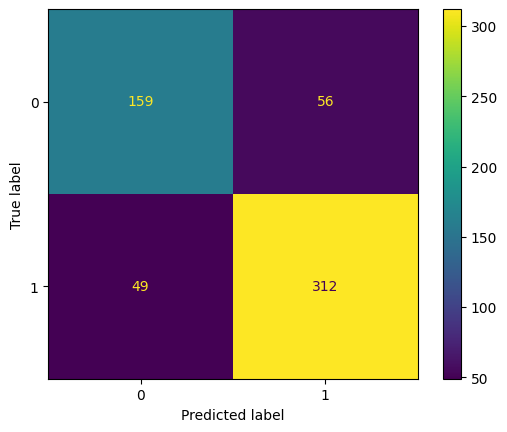

In [34]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_test)
plt.show()

The confusion matrix is a visual way to understand where our model is underperforming. The main diagonal of the matrix contains the number of correctly classified samples, while all other elements represent misclassified samples. The x-axis gives the predicted label, while the y-axis gives the ground-truth label.

# Visualize molecular structures (optional)

We may also look at some chemical structures that were classified correctly and incorrectly using RDKit.

In [35]:
y_pred_all = mlp.predict(X)

In [36]:
correct_toxic_indices = np.where(np.logical_and(y_pred_all == 1, y == 1))[0]
correct_nontoxic_indices = np.where(np.logical_and(y_pred_all == 0, y == 0))[0]
incorrect_toxic_indices = np.where(np.logical_and(y_pred_all == 1, y == 0))[0]
incorrect_nontoxic_indices = np.where(np.logical_and(y_pred_all == 0, y == 1))[0]

Correctly classified as toxic

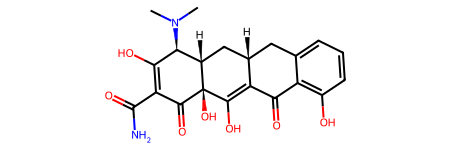

In [37]:
index = 32 # Change to see a different molecule
Chem.MolFromSmiles(df["CANONICAL SMILES"][correct_toxic_indices[index]])

Correctly classified as non-toxic

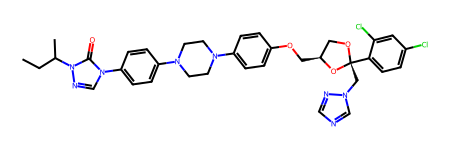

In [38]:
index = 36 # Change to see a different molecule
Chem.MolFromSmiles(df["CANONICAL SMILES"][correct_nontoxic_indices[index]])

Inorrectly classified as toxic

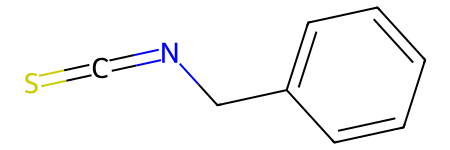

In [39]:
index = 45 # Change to see a different molecule
Chem.MolFromSmiles(df["CANONICAL SMILES"][incorrect_toxic_indices[index]])

Inorrectly classified as nontoxic

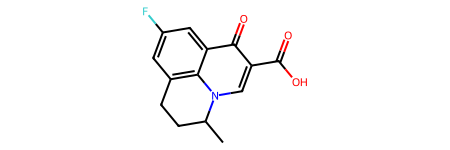

In [40]:
index = 3 # Change to see a different molecule
Chem.MolFromSmiles(df["CANONICAL SMILES"][incorrect_nontoxic_indices[index]])